In [1]:
from autoencoder import Autoencoder
from utils import increase_batch, mini_batch
from utils import read_EM

import tensorflow as tf
import numpy as np
import time
import pdb
import matplotlib.pyplot as plt
    
x_train, t_train, x_test = read_EM("./Dataset/")

# Training CNN

In [2]:
opt = {'LR': 5e-4,
       'input_shape': [None, x_train.shape[1], x_train.shape[2], 1],
       'output_shape': [None, t_train.shape[1], t_train.shape[2], 1],}
ae = Autoencoder(opt)

# Encoder
ae.add_cnn(filter_shape=[3, 3, 1, 64], name='L1')                                 # after: (512, 512, 64)
ae.add_cnn(filter_shape=[3, 3, 64, 64], name='L2')                                # after: (512, 512, 64)
ae.add_pooling(ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], name='L3')               # after: (256, 256, 64)
ae.add_cnn(filter_shape=[3, 3, 64, 128], name='L4')                               # after: (256, 256, 128)
ae.add_cnn(filter_shape=[3, 3, 128, 128], name='L5')                              # after: (256, 256, 128)
ae.add_pooling(ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], name='L6')               # after: (128, 128, 128)
ae.add_cnn(filter_shape=[3, 3, 128, 256], name='L7')                              # after: (128, 128, 256)
ae.add_cnn(filter_shape=[3, 3, 256, 256], name='L8')                              # after: (128, 128, 256)
ae.add_pooling(ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], name='L9')               # after: (64, 64, 256)
ae.add_cnn(filter_shape=[3, 3, 256, 512], name='L10')                             # after: (64, 64, 512)
ae.add_cnn(filter_shape=[3, 3, 512, 512], name='L11')                             # after: (64, 64, 512)
# Decoder
ae.add_decnn(filter_shape=[2, 2, 512, 512], strides=[1, 2, 2, 1], output_shape=[1, 128, 128, 512], name='L12')
ae.add_cnn(filter_shape=[3, 3, 512, 256], name='L13')                             # after: (128, 128, 256)
ae.add_cnn(filter_shape=[3, 3, 256, 256], name='L14')                             # after: (128, 128, 256)
ae.add_decnn(filter_shape=[2, 2, 256, 256], strides=[1, 2, 2, 1], output_shape=[1, 256, 256, 256], name='L15')
ae.add_cnn(filter_shape=[3, 3, 256, 128], name='L16')                             # after: (256, 256, 128)
ae.add_cnn(filter_shape=[3, 3, 128, 128], name='L17')                             # after: (256, 256, 128)
ae.add_decnn(filter_shape=[2, 2, 128, 128], strides=[1, 2, 2, 1], output_shape=[1, 512, 512, 128], name='L18')
ae.add_cnn(filter_shape=[3, 3, 128, 64], name='L19')                              # after: (512, 512, 64)
ae.add_cnn(filter_shape=[3, 3, 64, 1], name='L20')                                # after: (512, 512, 1)

# Loss
def loss(y, t):
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=t, logits=y)
    loss = tf.reduce_mean(loss)
    return loss
ae.add_loss(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [3]:
epoch = 30
batch_size = increase_batch(start=1, bound=3, rate=1e-3)
for ep in range(epoch):
    count = 0
    total_loss = 0
    start = time.time()
    for x, t in mini_batch(x_train, t_train, batch_generator=batch_size):
        count += 1
        feed_dict = {
            ae.x: np.expand_dims(x, axis=3),
            ae.t: np.expand_dims(t, axis=3),
        }
        loss, _ = sess.run([ae.loss, ae.optimize], feed_dict=feed_dict)
        total_loss += loss
    end = time.time()
    print("Epoch: {:<4} Loss: {:<10.9f} Time: {:<10.2f} ".format(ep, total_loss/count, end-start))

Epoch: 0    Loss: 0.545017394 Time: 35.14      
Epoch: 1    Loss: 0.482093749 Time: 23.55      
Epoch: 2    Loss: 0.352898179 Time: 23.68      
Epoch: 3    Loss: 0.312989191 Time: 23.67      
Epoch: 4    Loss: 0.291188328 Time: 23.71      
Epoch: 5    Loss: 0.272382831 Time: 23.67      
Epoch: 6    Loss: 0.285789216 Time: 23.63      
Epoch: 7    Loss: 0.275181590 Time: 23.63      
Epoch: 8    Loss: 0.261515312 Time: 23.64      
Epoch: 9    Loss: 0.249769748 Time: 23.67      
Epoch: 10   Loss: 0.237624104 Time: 23.67      
Epoch: 11   Loss: 0.228292083 Time: 23.67      
Epoch: 12   Loss: 0.219403415 Time: 23.70      
Epoch: 13   Loss: 0.221577792 Time: 23.69      
Epoch: 14   Loss: 0.214072873 Time: 23.69      
Epoch: 15   Loss: 0.209931634 Time: 23.66      
Epoch: 16   Loss: 0.202556462 Time: 23.65      
Epoch: 17   Loss: 0.195915322 Time: 23.74      
Epoch: 18   Loss: 0.190540283 Time: 23.67      
Epoch: 19   Loss: 0.190779323 Time: 23.67      
Epoch: 20   Loss: 0.184108554 Time: 23.6

In [4]:
saver = tf.train.Saver()
save_path = saver.save(sess, "./Models/cnn_small.ckpt")
print("Model saved in path: " + save_path)

Model saved in path: ./Models/cnn_small.ckpt


# Test

In [3]:
saver = tf.train.Saver()
saver.restore(sess, './Models/cnn_small.ckpt')

INFO:tensorflow:Restoring parameters from ./Models/cnn_small.ckpt


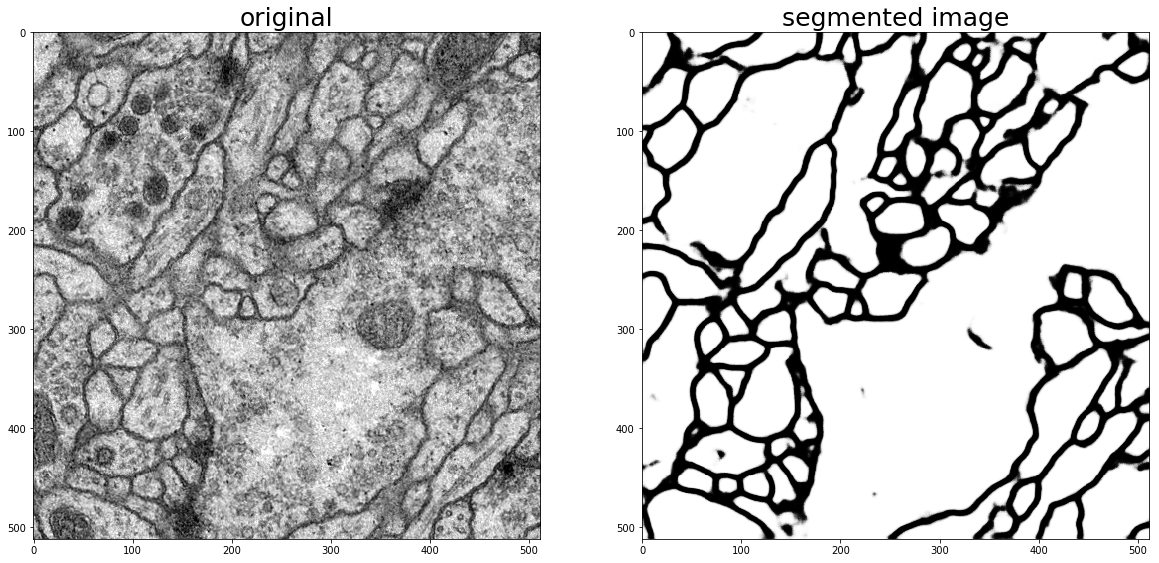

In [4]:
feed_dict = {
    ae.x: np.expand_dims(x_test[0:1], axis=3),
    #ae.t: np.expand_dims(t_test[0:1], axis=3),
}

y_test = sess.run(ae.neurons[-1], feed_dict=feed_dict)
y_test = np.squeeze(y_test)
y_test = sess.run(tf.sigmoid(y_test))

%matplotlib inline
f, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].set_title("original", size=25)
ax[0].imshow(x_test[0], cmap="gray")
ax[1].set_title("segmented image", size=25)
ax[1].imshow(y_test, cmap="gray")
plt.show()

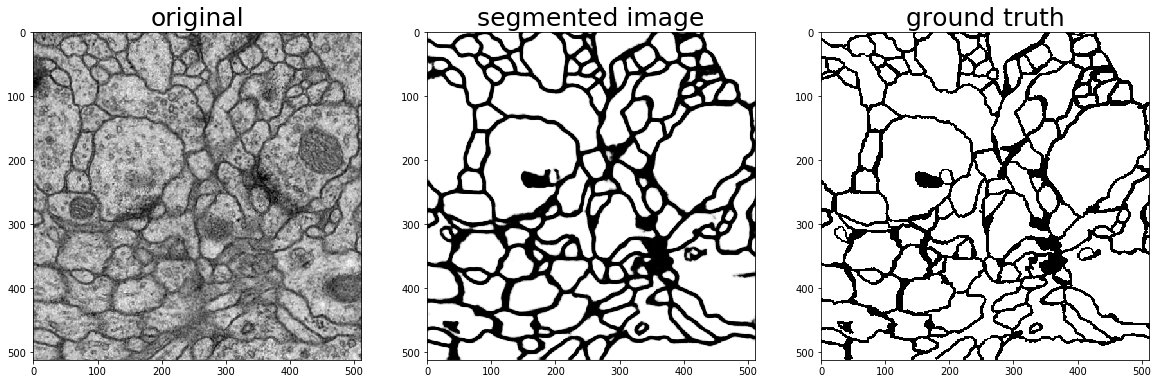

In [5]:
feed_dict = {
    ae.x: np.expand_dims(x_train[0:1], axis=3),
    #ae.t: np.expand_dims(t_test[0:1], axis=3),
}

y_test = sess.run(ae.neurons[-1], feed_dict=feed_dict)
y_test = np.squeeze(y_test)
y_test = sess.run(tf.sigmoid(y_test))

%matplotlib inline
f, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].set_title("original", size=25)
ax[0].imshow(x_train[0], cmap="gray")
ax[1].set_title("segmented image", size=25)
ax[1].imshow(y_test, cmap="gray")
ax[2].set_title('ground truth', size=25)
ax[2].imshow(t_train[0], cmap="gray")
plt.show()